# Principal Component analysis Dimensionaity reduction

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import itertools as it

def friedman_aligned_ranks_test(*args):
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    aligned_observations = []
    for i in range(n):
        loc = sp.mean([col[i] for col in args])
        aligned_observations.extend([col[i] - loc for col in args])
        
    aligned_observations_sort = sorted(aligned_observations)
    
    aligned_ranks = []
    for i in range(n):
        row = []
        for j in range(k):
            v = aligned_observations[i*k+j]
            row.append(aligned_observations_sort.index(v) + 1 + (aligned_observations_sort.count(v)-1)/2.)
        aligned_ranks.append(row)

    rankings_avg = [sp.mean([case[j] for case in aligned_ranks]) for j in range(k)]
    rankings_cmp = [r/sp.sqrt(k*(n*k+1)/6.) for r in rankings_avg]

    r_i = [np.sum(case) for case in aligned_ranks]
    r_j = [np.sum([case[j] for case in aligned_ranks]) for j in range(k)]
    T = (k-1) * (sp.sum(v**2 for v in r_j) - (k*n**2/4.) * (k*n+1)**2) / float(((k*n*(k*n+1)*(2*k*n+1))/6.) - (1./float(k))*sp.sum(v**2 for v in r_i))

    p_value = 1 - st.chi2.cdf(T, k-1)

    return T, p_value, rankings_avg, rankings_cmp

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import time

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
ps_data=pd.read_csv('F:/Ministry ICERT/Phishing_Legitimate/phishing_new_sorted.csv')
ps_data=ps_data.drop(['id'],axis=1)
ps_data.head(5)

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,2,1,0,25,0,0,0,0,0,0,...,0,0,0,2,2,0,2,1,2,0
1,2,1,0,24,0,0,0,0,0,0,...,1,0,0,2,2,0,2,1,2,0
2,2,1,0,21,0,0,0,0,0,0,...,0,0,0,2,2,2,2,1,2,0
3,2,1,0,22,0,0,0,0,0,0,...,1,0,0,2,2,0,2,1,2,0
4,2,1,0,25,0,0,0,0,0,0,...,0,0,0,2,2,0,1,0,2,0


In [5]:
data=pd.read_csv('C:/Users/hp/PCA.csv')
data.head(5)
data.iloc[:,1:10]


,GaussianNB,LogisticRegression,RandomForest,Adaboost,XGBoost,KNeighbors,SVM,DecisionTreeClassifier
0,0.149254,0.194030,0.940299,0.940299,0.940299,0.910448,0.265944,0.910448
1,0.820896,0.850746,0.925373,0.880597,0.895522,0.910448,0.373134,0.880597
2,0.761194,0.701493,0.835821,0.761194,0.835821,0.835821,0.626866,0.776119
3,0.746269,0.671642,0.850746,0.865672,0.880597,0.791045,0.641791,0.880597
4,0.671642,0.716418,0.895522,0.895522,0.880597,0.791045,0.552239,0.910448
5,0.850746,0.805970,0.880597,0.895522,0.895522,0.925373,0.731343,0.865672
6,0.656716,0.656716,0.850746,0.850746,0.835821,0.731343,0.611940,0.776119
7,0.820896,0.850746,0.895522,0.895522,0.865672,0.805970,0.850746,0.820896
8,0.880597,0.835821,0.865672,0.925373,0.880597,0.925373,0.820896,0.835821
9,0.880597,0.835821,0.925373,0.865672,0.925373,0.940299,0.761194,0.850746


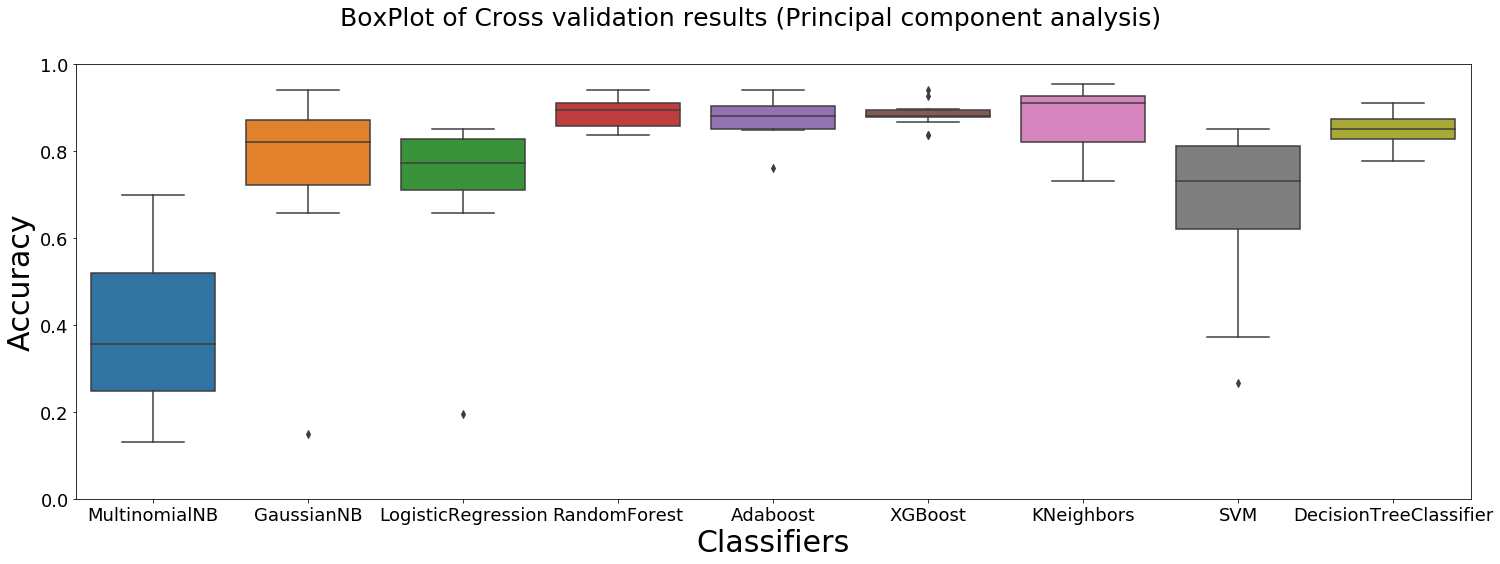

In [6]:
# rcParams['figure.figsize'] = 25,7
fig, ax = plt.subplots(figsize=(25,8))
boxplot=sns.boxplot(data=data)
boxplot.set_ylim([0,1.0])
fig.suptitle('BoxPlot of Cross validation results (Principal component analysis)', fontsize=25)
plt.ylabel('Accuracy',fontsize=30)
plt.xlabel('Classifiers',fontsize=30)
plt.tick_params(axis='both',which='major',colors='black',labelsize=18)
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/PCA2.png',dpi=300)
plt.show()

In [7]:
X=ps_data.iloc[:,1:48]
y=ps_data['CLASS_LABEL']

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2',
                                                                 'principal component 3', 'principal component 4',
                                                                 'principal component 5', 'principal component 6',
                                                                 'principal component 7', 'principal component 8'])

In [9]:
finalDf = pd.concat([principalDf, ps_data[['CLASS_LABEL']]], axis = 1)
finalDf.head(5)
finalDf.shape

(1000, 9)

In [10]:
X=finalDf.iloc[:,0:8]
y=finalDf['CLASS_LABEL']
X.head(5)

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8
0,-56.471794,17.889923,-1.128171,0.889051,1.640363,1.483583,0.349050,0.295917
1,-57.309493,17.901031,-2.259404,0.756237,1.676434,1.426627,0.434624,0.262464
2,-59.802143,17.950395,-4.776258,0.524976,1.495538,1.162700,-1.179204,0.007165
3,-58.983768,17.926896,-4.518919,0.486423,1.692447,1.411103,0.448817,0.181288
4,-56.449348,17.888812,-0.286961,1.046558,1.691523,1.630103,0.997152,0.104573


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
print(scaler.fit(X))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [13]:
print(scaler.data_max_)

[209.66875212 137.60065167  72.40296328  49.51288135  17.90157163
   8.10557222   2.81364851   7.77655377]


In [14]:
X1=scaler.transform(X)
X1

array([[0.03930099, 0.49523726, 0.1771267 , ..., 0.52854435, 0.48304555,
        0.49207608],
       [0.03627712, 0.4952841 , 0.16446728, ..., 0.5244893 , 0.500995  ,
        0.48980466],
       [0.02727929, 0.49549224, 0.13630163, ..., 0.50569892, 0.16249135,
        0.47247026],
       ...,
       [0.13372908, 0.43566477, 0.23826862, ..., 0.44506861, 0.25229702,
        0.47603972],
       [0.0459176 , 0.47970744, 0.12332549, ..., 0.39982019, 0.61033703,
        0.4335807 ],
       [0.16137902, 0.41991374, 0.26310189, ..., 0.36746161, 0.68016154,
        0.47074515]])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=4)
# X[X < 0] = 0

In [16]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l1')
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators =100,random_state=11)
import xgboost
from xgboost import XGBClassifier
xg=XGBClassifier()
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha =0.2)
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,random_state=11)
from sklearn import tree
clf =  tree.DecisionTreeClassifier()

In [17]:
  #defining a dictionary of classifier
classifier={'MultinomialNB': mnb,'GaussianNB': gnb,'logistic': lr,'RandomForest': rfc,'Adaboost': abc,
            'XGBoost':xg,'KNeighbors':knn,'SVM':svc,'DecisionTreeClassifier':clf }

#Classifi=['MultinomialNB','GaussianNB','LogisticR','RandomForest','Adaboost','XGBoost','KNeighbors',
#          'SVM','DecisionTreeClassifier']

classifi=sorted(classifier.keys())
print(classifi)
df=pd.DataFrame(classifi,columns=['Classiifier'])
df

['Adaboost', 'DecisionTreeClassifier', 'GaussianNB', 'KNeighbors', 'MultinomialNB', 'RandomForest', 'SVM', 'XGBoost', 'logistic']


,Classiifier
0,Adaboost
1,DecisionTreeClassifier
2,GaussianNB
3,KNeighbors
4,MultinomialNB
5,RandomForest
6,SVM
7,XGBoost
8,logistic



 classifier Adaboost 
 results 
 [0.94029851 0.88059701 0.76119403 0.86567164 0.89552239 0.88059701
 0.8358209  0.88059701 0.92537313 0.86567164 0.84848485 0.86363636
 0.92424242 0.90909091 0.81818182]

 classifier Adaboost 
 mean results 
 0.8729986431478967

 classifier DecisionTreeClassifier 
 results 
 [0.92537313 0.89552239 0.79104478 0.86567164 0.8358209  0.89552239
 0.79104478 0.80597015 0.82089552 0.86567164 0.78787879 0.81818182
 0.86363636 0.87878788 0.87878788]

 classifier DecisionTreeClassifier 
 mean results 
 0.8479873360470375

 classifier GaussianNB 
 results 
 [0.14925373 0.82089552 0.76119403 0.74626866 0.67164179 0.85074627
 0.65671642 0.82089552 0.88059701 0.88059701 0.86363636 0.86363636
 0.6969697  0.90909091 0.93939394]

 classifier GaussianNB 
 mean results 
 0.7674355495251016

 classifier KNeighbors 
 results 
 [0.91044776 0.91044776 0.8358209  0.79104478 0.79104478 0.92537313
 0.73134328 0.80597015 0.92537313 0.94029851 0.95454545 0.90909091
 0.90909091 0.9

<Figure size 2160x1800 with 0 Axes>

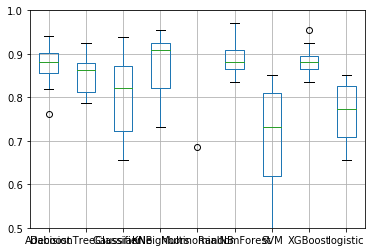

In [18]:
#predict and storing score of each classifier
parameter = []
res=[]
plt.figure(figsize=(30,25))
fig, ax = plt.subplots()
res=pd.DataFrame(res)
for n,c in sorted(classifier.items()):
    kfold = KFold(n_splits=15, random_state=0)
    results = cross_val_score(c, X1, y, cv=kfold)
    print("\n classifier",n,"\n results \n",results)
    print("\n classifier",n,"\n mean results \n",results.mean())
    parameter.append((n,[results.mean()]))
#     testres=friedman_aligned_ranks_test(results)
    result=pd.DataFrame(results)
#     print(result)
#     sns.boxplot( result)
    res=pd.concat([res,result],axis=1,ignore_index=True)
#     plt.ylabel('Accuracy')
#     plt.xticks(parameter_df['mean'])
print(res)
res.columns = ['Adaboost','DecisionTreeClassifier','GaussianNB','KNeighbors','MultinomialNB','RandomForest','SVM',
          'XGBoost','logistic']

boxplot = res.boxplot(grid=True,figsize=(25,15))
#boxplot1 = res.boxplot(grid=True,figsize=(25,15))

boxplot.set_ylim([0.5,1.0])
#boxplot1.set_ylim([0.5,1.0])
plt.show()


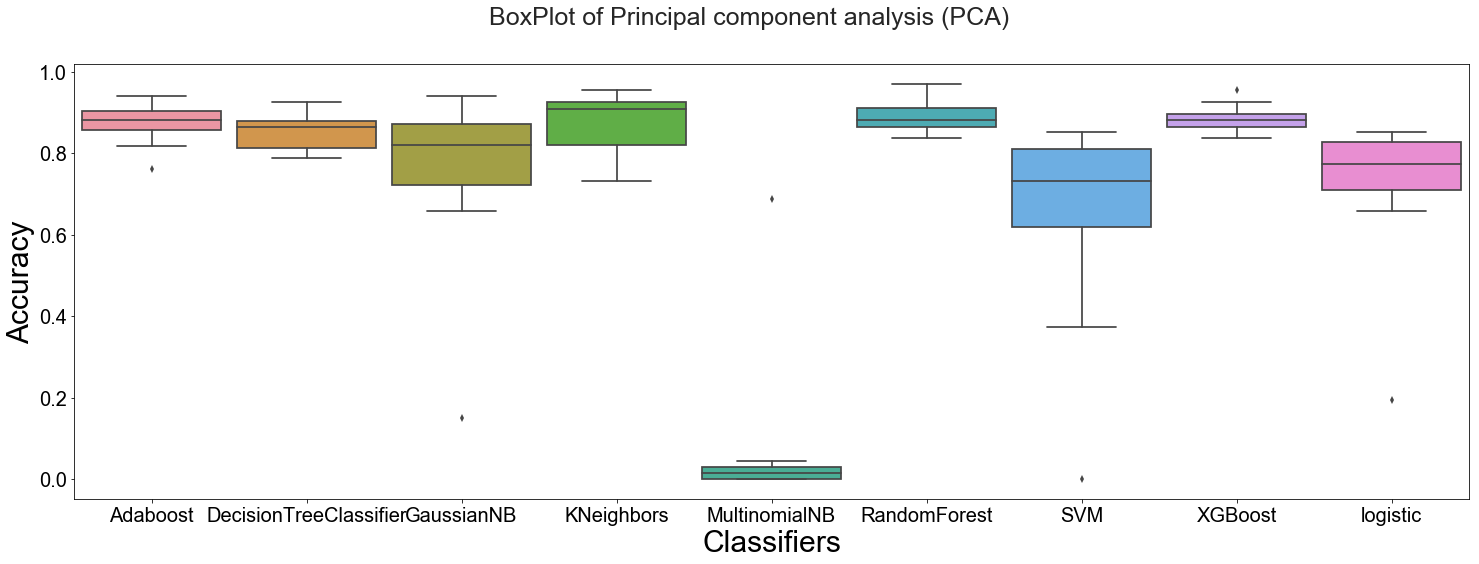

In [19]:
# rcParams['figure.figsize'] = 25,7
fig, ax = plt.subplots(figsize=(25,8))
sns.set(style="whitegrid")
boxplot=sns.boxplot(data=res,width=0.9)
# boxplot.set_ylim([0,1.0])
fig.suptitle('BoxPlot of Principal component analysis (PCA)', fontsize=25)
plt.ylabel('Accuracy',fontsize=30)
plt.xlabel('Classifiers',fontsize=30)
plt.tick_params(axis='both', which='major', colors='black', labelsize=20)
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/PCA2.png')
plt.show()

In [20]:
parameter_df=pd.DataFrame.from_items(parameter,orient='index',columns=['mean'])
parameter_df

,mean
Adaboost,0.872999
DecisionTreeClassifier,0.847987
GaussianNB,0.767436
KNeighbors,0.876195
MultinomialNB,0.057727
RandomForest,0.890005
SVM,0.661646
XGBoost,0.885029
logistic,0.734223


In [21]:
p=friedman_aligned_ranks_test( res['Adaboost'],res['DecisionTreeClassifier'],res['GaussianNB'],res['KNeighbors'],
                              res['MultinomialNB'],res['RandomForest'],res['SVM'],res['XGBoost'],res['logistic'])
print(p)

# Chi2-value : float The computed Chi2-value of the test.
# p-value : float The associated p-value from the Chi2-distribution.
# rankings : array_like The ranking for each group.
# pivots : array_like The pivotal quantities for each group.

(84.2686049718542, 6.772360450213455e-15, [91.9, 80.2, 60.53333333333333, 95.96666666666667, 8.366666666666667, 101.13333333333334, 32.5, 98.43333333333334, 42.96666666666667], [6.434286986108705, 5.615123136952319, 4.238181054324776, 6.7190106031944, 0.5857838351517174, 7.080749624901636, 2.275455136545516, 6.891711813557855, 3.008268380520174])


In [22]:
def predict(clf,X_test):
    return clf.predict(X_test)


 Classifier is: 
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=11)
 Total time in : 
 0.2656056880950928
Confusion_matrix 
 [[137  17]
 [ 12 134]]
0.8874172185430463
0.9178082191780822
AUC: 0.904

 Classifier is: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 Total time in : 
 0.015625953674316406
Confusion_matrix 
 [[128  26]
 [ 19 127]]
0.8300653594771242
0.8698630136986302
AUC: 0.851

 Classifier is: 
 GaussianNB(priors=None, var_smoothing=1e-09)
 Total time in : 
 0.0
Confusion_matrix 
 [[123  31]
 [ 12 134]]
0.8121212121212121
0.9178082191780822
AUC: 0.858

 Classifier is: 
 KNeighborsClassifier(algorithm

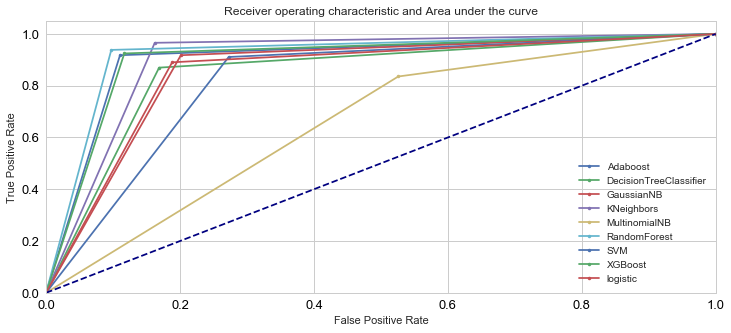

In [23]:
score = []
plt.subplots(figsize=(12,5))
for n,c in sorted(classifier.items()):
    start = time.time()
    c.fit(X_train,y_train)
    pred = predict(c,X_test)
    end = time.time()
    print("\n Classifier is: \n",c)
    print(" Total time in : \n",end - start)
#     print("",c)
    score.append((n,[accuracy_score(y_test,pred,normalize=True),metrics.precision_score(y_test, pred),
                    metrics.recall_score(y_test, pred)]))
    print("Confusion_matrix \n",confusion_matrix(y_test,pred))
    precision=metrics.precision_score(y_test, pred)
    print(precision)
    recall=metrics.recall_score(y_test, pred)
    print(recall)
#     ROC AND AUC CURVE
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    # calculate AUC
    auc = roc_auc_score(y_test, pred)
    print('AUC: %.3f' % auc)
    plt.plot(fpr, tpr,marker='.',label=n)
    # plot no skill
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    # plot the roc curve for the model

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic and Area under the curve',fontsize=12)
plt.legend(loc=0,fontsize='small')
plt.tick_params(axis='both', which='major', colors='black', labelsize=13)
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/PCA3.png')
plt.show()

In [24]:
score_df=pd.DataFrame.from_items(score,orient='index',columns=['scores','Precision','Recall'])
#Adding accuracy column
score_df['Accuracy (%)']=score_df['scores']*100
score_df

,scores,Precision,Recall,Accuracy (%)
Adaboost,0.903333,0.887417,0.917808,90.333333
DecisionTreeClassifier,0.850000,0.830065,0.869863,85.000000
GaussianNB,0.856667,0.812121,0.917808,85.666667
KNeighbors,0.900000,0.849398,0.965753,90.000000
MultinomialNB,0.650000,0.600985,0.835616,65.000000
RandomForest,0.920000,0.901316,0.938356,92.000000
SVM,0.816667,0.760000,0.910959,81.666667
XGBoost,0.903333,0.882353,0.924658,90.333333
logistic,0.850000,0.817610,0.890411,85.000000


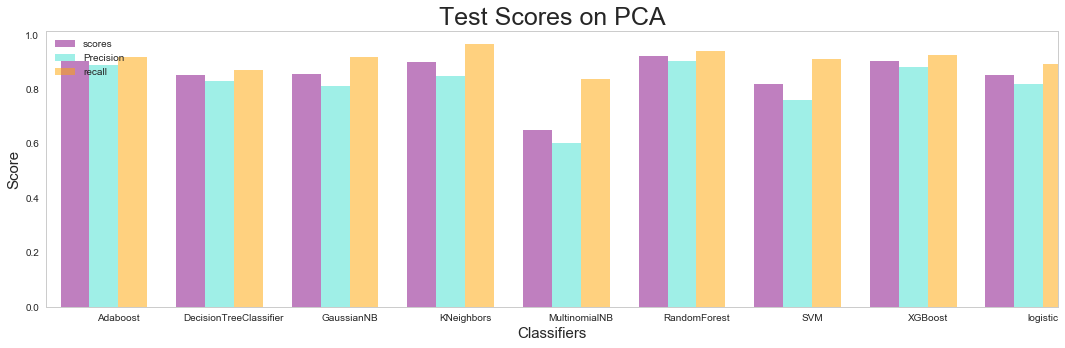

In [26]:
pos = list(range(len(df['Classiifier']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,5)) 
# Create a bar with pre_score data,in position pos,
plt.bar(pos,score_df['scores'],width,alpha=0.5,color='purple',label=score_df['scores'][0]) 
plt.bar([p + width for p in pos],score_df['Precision'],width,alpha=0.5,color='turquoise',label=score_df['Precision'][1]) 
plt.bar([p + width*2 for p in pos],score_df['Recall'],width,alpha=0.5, color='orange',label=score_df['Recall']) 

ax.set_ylabel('Score',fontsize=15)
ax.set_xlabel('Classifiers',fontsize=15)
ax.set_title('Test Scores on PCA',fontsize=25)
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df['Classiifier'])
plt.xlim(min(pos)-width, max(pos)+width*2)
# plt.ylim([0, max(score_df['scores'] + score_df['Precision'] + score_df['Recall'])] )
# plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.legend(['scores', 'Precision', 'recall'], loc='upper left')
plt.grid()
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/PCA1.png')
plt.show()